In [69]:
import cvxpy as cp
import numpy as np
import incidence
from pjm5bus import buses, generators, lines, offers, reference_bus, base_power

In [70]:
line_bus = incidence.line_bus(buses=buses, lines=lines)
offer_bus = incidence.offer_bus(offers=offers, buses=buses, generators=generators)
reference_bus_index = incidence.reference_bus(buses, reference_bus)
offers = offers.merge(generators, left_on="generator_id", right_on="id")

In [71]:
p = cp.Variable(len(offers), name="p")  # dispatched/injected power [MW]
f = cp.Variable(len(lines), name="f")  # line flows [MW]
θ = cp.Variable(len(buses), name="θ")  # bus angles [rad]

In [72]:
balance_constraints = [
    cp.sum([p[o] * offer_bus[o, b] for o in offers.index])
    + cp.sum([f[ell] * line_bus[ell, b] for ell in lines.index])
    == buses.at[b, "load"]
    for b in buses.index
]

In [73]:
flow_constraints = [
    f[ell]
    == cp.sum([line_bus[ell, b] * θ[b] for b in buses.index])
    * base_power
    / lines.at[ell, "reactance"]
    for ell in lines.index
]

In [74]:
objective = cp.Minimize(cp.sum([offers.at[o, "price"] * p[o] for o in offers.index]))

In [75]:
problem = cp.Problem(
    objective,
    [
        *balance_constraints,
        *flow_constraints,
        θ[reference_bus_index] == 0,
        f >= -lines["capacity"],
        f <= lines["capacity"],
        p >= 0,
        p <= offers["quantity"],
    ],
)
print(problem)

minimize 14.0 @ p[0] + 15.0 @ p[1] + 30.0 @ p[2] + 40.0 @ p[3] + 10.0 @ p[4] + 140.0 @ p[5] + 150.0 @ p[6] + 300.0 @ p[7] + 400.0 @ p[8] + 100.0 @ p[9]
subject to p[0] @ 1.0 + p[1] @ 1.0 + p[2] @ 0.0 + p[3] @ 0.0 + p[4] @ 0.0 + p[5] @ 1.0 + p[6] @ 1.0 + p[7] @ 0.0 + p[8] @ 0.0 + p[9] @ 0.0 + f[0] @ -1.0 + f[1] @ -1.0 + f[2] @ -1.0 + f[3] @ 0.0 + f[4] @ 0.0 + f[5] @ 0.0 == 0.0
           p[0] @ 0.0 + p[1] @ 0.0 + p[2] @ 0.0 + p[3] @ 0.0 + p[4] @ 0.0 + p[5] @ 0.0 + p[6] @ 0.0 + p[7] @ 0.0 + p[8] @ 0.0 + p[9] @ 0.0 + f[0] @ 1.0 + f[1] @ 0.0 + f[2] @ 0.0 + f[3] @ -1.0 + f[4] @ 0.0 + f[5] @ 0.0 == 300.0
           p[0] @ 0.0 + p[1] @ 0.0 + p[2] @ 1.0 + p[3] @ 0.0 + p[4] @ 0.0 + p[5] @ 0.0 + p[6] @ 0.0 + p[7] @ 1.0 + p[8] @ 0.0 + p[9] @ 0.0 + f[0] @ 0.0 + f[1] @ 0.0 + f[2] @ 0.0 + f[3] @ 1.0 + f[4] @ -1.0 + f[5] @ 0.0 == 300.0
           p[0] @ 0.0 + p[1] @ 0.0 + p[2] @ 0.0 + p[3] @ 1.0 + p[4] @ 0.0 + p[5] @ 0.0 + p[6] @ 0.0 + p[7] @ 0.0 + p[8] @ 1.0 + p[9] @ 0.0 + f[0] @ 0.0 + f[1] @ 1.0 + 

In [76]:
problem.solve(solver="ECOS")
print(f"Optimal dispatch cost: ${problem.value:.2f} / h")

Optimal dispatch cost: $17479.90 / h


In [77]:
offers["dispatch"] = p.value
lines["flow"] = f.value
buses["angle"] = θ.value
buses["price"] = [-c.dual_value for c in balance_constraints]

#
# Prostprocessing
#
agg = offers.groupby("generator_id").agg({"dispatch": "sum", "quantity": "sum"})
generators["dispatch"] = generators["id"].map(agg["dispatch"])
generators["capacity"] = generators["id"].map(agg["quantity"])
generators["utilization"] = generators["dispatch"] / generators["capacity"]
generators["revenue"] = generators["dispatch"] * generators["bus_id"].map(
    buses.set_index("id")["price"]
)
lines["utilization"] = lines["flow"].abs() / lines["capacity"]
offers["utilization"] = offers["dispatch"] / offers["quantity"]
offers["bus_id"] = offers["generator_id"].map(generators.set_index("id")["bus_id"])
offers["tranche"] = offers.groupby("generator_id").cumcount() + 1
offers["id"] = offers["generator_id"] + "/" + offers["tranche"].astype(str)

#
# Congestion pricing
#

In [78]:
offer_dispatch = offers["dispatch"]
line_flow = lines["flow"]
bus_angle = buses["angle"]
line_reactance = lines["reactance"]

In [79]:
assert np.allclose(
    (line_bus @ bus_angle) * base_power / line_reactance,
    line_flow,
)

In [80]:
bus_injections = offer_dispatch @ offer_bus - buses["load"]
free_bus_ids = [b for b in buses.index if b != reference_bus_index]
K = line_bus[:, free_bus_ids]
KtB = K.T @ np.diag(1.0 / line_reactance)
SF = np.linalg.solve(KtB @ K, -KtB).T

In [81]:
assert np.allclose(bus_injections, -line_flow @ line_bus)
assert np.allclose(SF @ bus_injections[free_bus_ids], line_flow)
assert np.allclose(
    (SF @ offer_bus[:, free_bus_ids].T) @ offer_dispatch
    - SF @ buses.loc[free_bus_ids, "load"],
    line_flow,
)

In [82]:
p = cp.Variable(len(offers), name="p")  # dispatched/injected power [MW]
f = cp.Variable(len(lines), name="f")  # line flows [MW]

In [83]:
balance_constraint = cp.sum(p) == sum(buses["load"])

In [84]:
A = SF @ offer_bus[:, free_bus_ids].T
L = SF @ buses.loc[free_bus_ids, "load"]
flow_constraints = [
    cp.sum([A[ell, o] * p[o] for o in offers.index]) - L[ell] == f[ell]
    for ell in lines.index
]

In [85]:
flow_lower_bounds = f >= -lines["capacity"]
flow_upper_bounds = f <= lines["capacity"]

In [86]:
objective = cp.Minimize(cp.sum([offers.at[o, "price"] * p[o] for o in offers.index]))

In [87]:
problem = cp.Problem(
    objective,
    [
        balance_constraint,
        *flow_constraints,
        flow_lower_bounds,
        flow_upper_bounds,
        p >= 0,
        p <= offers["quantity"],
    ],
)

In [88]:
problem.solve(solver="ECOS")

assert np.allclose(p.value, offers["dispatch"])
assert np.allclose(f.value, lines["flow"])
print(f"Optimal dispatch cost: ${problem.value:.2f} / h")

Optimal dispatch cost: $17479.90 / h


In [89]:
buses["lmp_energy"] = -balance_constraint.dual_value

In [90]:
mu_lower = -flow_lower_bounds.dual_value
mu_upper = -flow_upper_bounds.dual_value
buses["lmp_congestion"] = 0.0
buses.loc[free_bus_ids, "lmp_congestion"] = SF.T @ (mu_upper - mu_lower)

#
# Plotting
#

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import pygraphviz as pgv

node_attributes = dict(
    style="filled",
    fixedsize="true",
    width=0.25,  # [inch]
    height=0.25,  # [inch]
    labelloc="c",
)
edge_attributes = dict(labeldistance="1.5")

graph = pgv.AGraph(
    strict=True,
    directed=True,
    name="DC-OPF",
    graph_attr=dict(
        fontsize=6,
        fontname="Helvetica",
        margin="0.1",
        size="6,8!",  # [inch], '!' forces size
        ratio="fill",  # fit to size
        overlap="false",  # neato only
        sep="+1.0in",  # [point] neato only
        # nodesep="1.2",  # dot only
        # ranksep="1.2",  # dot only
    ),
)

xy = np.vstack((buses["x"], buses["y"])).T
xy_min = np.min(xy, axis=0)
xy_max = np.max(xy, axis=0)
xy_mid = (xy_min + xy_max) * 0.5
xy_centered = xy - xy_mid
xy_normalized = 10 * xy_centered / np.max(np.abs(xy_centered))

bus_load_norm = mc.Normalize(vmin=min(buses["load"]), vmax=max(buses["load"]))
bus_load_cmap = cm.coolwarm  # coolwarm | inferno | magma | plasma etc.
for i, bus in buses.iterrows():
    rgba = bus_load_cmap(bus_load_norm(bus["load"]))
    x, y = xy_normalized[i, :]
    graph.add_node(
        bus["id"],
        label=f"{bus['id']}\n{bus['load']:.1f}MW\n${bus['price']:.2f}/MWh",
        color=mc.to_hex(rgba),
        # pin=True,
        pos=f"{x},{y}",
        shape="square",
        **node_attributes,
    )

generator_cmap = plt.get_cmap(name="tab10", lut=len(generators))
generator_color = {gid: generator_cmap(i) for i, gid in enumerate(generators["id"])}
for _, offer in offers.iterrows():
    rgba = generator_color[offer["generator_id"]]
    graph.add_node(
        offer["id"],
        label=f"{offer['id']}\n≤{offer['quantity']}MW\n${offer['price']}/MWh",
        color=mc.to_hex(rgba),
        pin=False,
        shape="circle",
        **node_attributes,
    )

edge_cmap = cm.coolwarm
for _, line in lines.iterrows():
    rgba = edge_cmap(line["utilization"])
    graph.add_edge(
        line["from_bus_id"],
        line["to_bus_id"],
        label=f"{line['flow']:.0f}MW\n{line['utilization']:.0f}%",
        color=mc.to_hex(rgba),
        **edge_attributes,
    )

for _, offer in offers.iterrows():
    rgba = edge_cmap(offer["utilization"])
    graph.add_edge(
        offer["id"],
        offer["bus_id"],
        label=f"{offer['dispatch']:.0f}MW",
        color=mc.to_hex(rgba),
        **edge_attributes,
    )

total_cost = sum(offers["dispatch"] * offers["price"])
load_payment = sum(buses["load"] * buses["price"])

graph.add_node(
    "__summary__",
    label=(
        f"    From Load: ${load_payment:.2f}/h\n"
        f"To Generators: ${total_cost:.2f}/h\n"
        f"   Difference: ${load_payment - total_cost:.2f}/h"
    ),
    rank="min",
    shape="none",
    # pos="7,-5",
    # pin=True,
)
graph.add_edge(
    "__summary__",
    buses.at[0, "id"],
    style="invis",
    weight=0,
)

# print(graph.string())

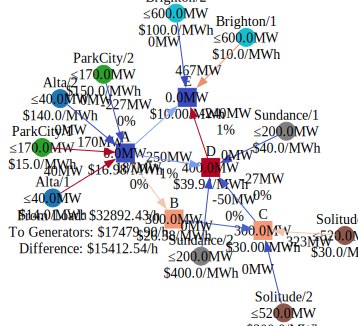

In [91]:
from IPython.display import SVG, display
import warnings

filename = "network.svg"
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    graph.layout(prog="neato")
    graph.draw(filename, format="svg", prog="neato")
display(SVG(filename=filename))